In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from PIL import Image
import cv2


## Image visualization and unpacking 

In this section we are going to read the file from the data and extract the images.

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict



In [3]:
# Carica il train_set (modifica in base alla posizione del tuo file)
train_set = unpickle('train')

# Estrai il nome dei file e i dati delle immagini
filenames = [f.decode('utf-8') for f in train_set[b'filenames']]  # Decodifica da byte a stringa


images_data = train_set[b'data']  # Supponiamo che le immagini siano in un array NumPy

# Crea una classe Dataset personalizzata
class CustomDataset(Dataset):
    def __init__(self, filenames, images_data, transform=None):
        self.filenames = filenames # nomi delle immagini
        self.images_data = images_data # nomi dei file 
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Carica l'immagine dal dataset
        img_data = self.images_data[idx]
        img = np.array(img_data, dtype=np.uint8).reshape(3, 32, 32)  # (C, H, W) -> RGB, adatta la forma a seconda del tuo caso

        img = Image.fromarray(np.transpose(img, (1, 2, 0)))  # Cambia l'ordine (H, W, C) a (C, H, W)

        
        if self.transform:
            img = self.transform(img)

        return img, self.filenames[idx]

# Definisci le trasformazioni, ad esempio: ridimensionamento, normalizzazione, ecc.
transform = transforms.Compose([
    transforms.ToTensor()  # Normalizzazione tipica
])


dataset = CustomDataset(filenames=filenames, images_data=images_data, transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle = False)



Filename: bos_taurus_s_000507.png


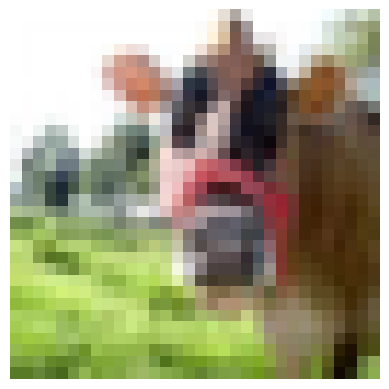

In [4]:
# Funzione per visualizzare un'immagine da un tensor
def imshow(tensor_img, yuv = False):
    # Converti il tensor da (C, H, W) a (H, W, C) per matplotlib
    
    img = tensor_img.numpy()
    
    if yuv == False:
        img = tensor_img.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
        plt.imshow(img)
        plt.axis('off')  # Nasconde gli assi
        plt.show()

    else:
        plt.imshow(img, cmap = 'jet')
        plt.axis('off')
        plt.show()

# Supponiamo che 'train_loader' sia già definito
# Carica un batch dal train_loader (ad esempio, il primo batch)
for batch in train_loader:
    image_tensor, filename = batch
    image_tensor = batch[0][0]  # La forma è (C, H, W)

    # Visualizza l'immagine
    print(f"Filename: {batch[1][0]}")
    imshow(image_tensor)

    break  # Visualizza solo la prima immagine del primo batch


Filename: bos_taurus_s_000507.png


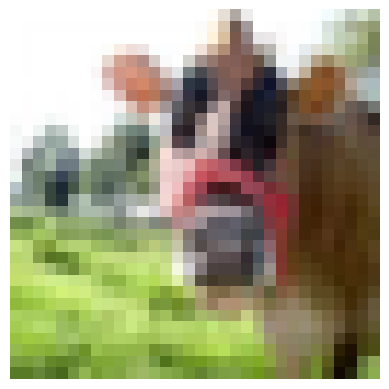

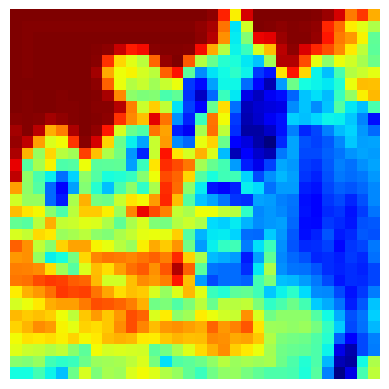

In [5]:
def rgb_to_yuv(image_tensor):
    """
    Converte un'immagine PyTorch tensor (C, H, W) da RGB a YUV usando OpenCV.
    """
    # Converti il tensor in NumPy e permuta gli assi (C, H, W) -> (H, W, C)
    img_np = image_tensor.permute(1, 2, 0).cpu().numpy()

    # Converti da [0,1] (normalizzato da ToTensor) a [0,255]
    img_np = (img_np * 255).astype(np.uint8)

    # Converti da RGB a YUV
    img_yuv = cv2.cvtColor(img_np, cv2.COLOR_RGB2YUV)

    return torch.tensor(img_yuv).permute(2, 0, 1)  # Riporta a (C, H, W)

for batch in train_loader:
    image_tensor, filename = batch  # Estrai dati dal batch

    image_rgb = image_tensor[0]  # Prima immagine del batch (RGB)
    image_yuv = rgb_to_yuv(image_rgb)  # Conversione a YUV

    print(f"Filename: {filename[0]}")
    imshow(image_rgb)
    imshow(image_yuv[0], yuv = True)  # Mostra solo il canale Y (Luminosità)

    break  # Visualizza solo il primo batch



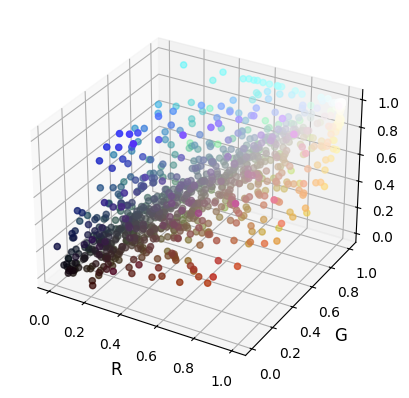

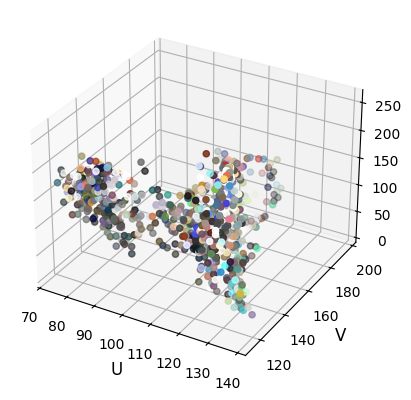

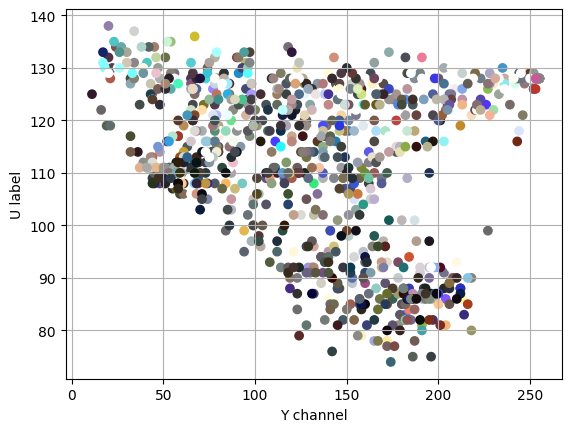

In [6]:
def plot_uv(train_loader, idx = 0):
    num = 0
    for batch in train_loader:
        if num == 1:
            break 
        image_tensor, filename = batch
        
        image_yuv = rgb_to_yuv(image_tensor[0])
        #print(image_tensor[0].shape)
        #image_yuv = cv2.cvtColor(image_tensor[0], cv2.COLOR_RGB2YUV)


        colors = image_tensor[0].reshape(-1, 3) 

        colors_yuv = image_yuv.reshape(-1, 3)

        Y_chan = image_yuv[0, :, :].flatten()
        U_chan = image_yuv[1, :, :].flatten()
        V_chan = image_yuv[2, :, :].flatten()


        
        #print(f"Filename: {filename[0]}")
        #imshow(image_tensor[0])
        ax = plt.axes(projection = '3d')
        ax.scatter(colors[:, 0], colors[:, 1], colors[:, 2], c = colors)
        ax.set_xlabel('R', fontsize=12)
        ax.set_ylabel('G', fontsize=12)
        ax.set_zlabel('B', fontsize=12)
        #plt.scatter(colors[:, 0], colors[:, 1])

        plt.show()
        
        ax = plt.axes(projection = '3d')
        ax.scatter(U_chan, V_chan, Y_chan, c = colors)
        ax.set_xlabel('U', fontsize=12)
        ax.set_ylabel('V', fontsize=12)
        ax.set_zlabel('Y', fontsize=12)
        plt.show()

        
        plt.scatter(Y_chan, U_chan, c = colors)
        plt.xlabel('Y channel')
        plt.ylabel('U label')
        plt.grid()


        
        num += 1
plot_uv(train_loader)

# CNN construction

In this first section we are going to construct the structure encoder <-> decoder of the network. 
The network works as following:
since our task is image colorization, we want to predict the `UV` channels given a grayscale image.
1. Input (grayscale image): we want to pass the grayscale channel `Y` to the network;
2. Target (color image): the target should contain the full color image, i.e. the `YUV` image.

In [7]:
# Creating a new Dataset class in order to extract the images (both RGB and YUV)

class CustomDataset(Dataset):
    def __init__(self, filenames, images_data, transform=None):
        self.filenames = filenames  # Names of the images
        self.images_data = images_data  # Images (in RGB or YUV format)
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Get image data (RGB image) from the dataset
        img_data = self.images_data[idx]
        
        
        img_rgb = np.array(img_data, dtype=np.uint8).reshape(3, 32, 32)  # Assuming RGB
        img_rgb = np.transpose(img_rgb, (1, 2, 0))  # Convert to HWC format
        
        # Convert the image from RGB to YUV
        img_yuv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2YUV)
        
        # Extract Y channel as input (grayscale)
        img_y = img_yuv[:, :, 0]  # Y channel (luminance)
        
        # Extract UV channels as target (chrominance)
        img_uv = img_yuv[:, :, 1:]  # U and V channels (chrominance)
        
        # Convert Y to 1 channel image (grayscale)
        #img_y = np.expand_dims(img_y, axis=-1)  # Add channel dimension (H, W) -> (H, W, 1)


        # Convert to Image format (needed for transforms)
        img_y = Image.fromarray(img_y.astype(np.uint8))
        img_uv = Image.fromarray(img_uv.astype(np.uint8))

        # Apply any transformations if provided
        if self.transform:
            img_y = self.transform(img_y)  # Grayscale input image
            img_uv = self.transform(img_uv)  # UV channels as output
            img_rgb = self.transform(img_rgb)


        return img_rgb, img_y, img_uv
    
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    #transforms.Normalize(mean=[0.485], std=[0.229])  # Normalize for grayscale input
])

train_set = unpickle('train')
filenames = [f.decode('utf-8') for f in train_set[b'filenames']]  # Decodifica da byte a stringa
images_data = train_set[b'data']  # Supponiamo che le immagini siano in un array NumPy

# Create dataset
dataset = CustomDataset(filenames=filenames, images_data=images_data, transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=False)


# Example of loading data
for img_y, img_uv, filename in train_loader:
    print(img_y.shape, img_uv.shape, filename)
    break  # Just checking the first batch




torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 32, 32]) tensor([[[[0.5020, 0.5020, 0.5020,  ..., 0.4863, 0.4745, 0.4627],
          [0.5020, 0.5020, 0.5020,  ..., 0.4627, 0.4392, 0.4353],
          [0.5020, 0.5020, 0.5020,  ..., 0.4549, 0.4275, 0.4314],
          ...,
          [0.3412, 0.3098, 0.3216,  ..., 0.4667, 0.4196, 0.4039],
          [0.3686, 0.3569, 0.3686,  ..., 0.4784, 0.4157, 0.3843],
          [0.3843, 0.3804, 0.3882,  ..., 0.4588, 0.3922, 0.3608]],

         [[0.5020, 0.5020, 0.5020,  ..., 0.4824, 0.4824, 0.4863],
          [0.5020, 0.5020, 0.5020,  ..., 0.4980, 0.4980, 0.4980],
          [0.5020, 0.5020, 0.5020,  ..., 0.4863, 0.4902, 0.4902],
          ...,
          [0.4549, 0.4549, 0.4549,  ..., 0.5412, 0.5255, 0.5216],
          [0.4549, 0.4588, 0.4549,  ..., 0.5216, 0.4863, 0.4824],
          [0.4510, 0.4549, 0.4549,  ..., 0.5098, 0.4627, 0.4549]]],


        [[[0.5020, 0.5020, 0.5020,  ..., 0.5020, 0.5020, 0.5020],
          [0.5020, 0.5020, 0.5020,  ..., 0.5020, 0

In [ ]:
# Funzione per visualizzare un'immagine da un tensor
def imshow(tensor_img, yuv=False):
    # Converti il tensor da (C, H, W) a (H, W, C) per matplotlib
    img = tensor_img.numpy()

    if not yuv:
        # Per immagini RGB
        img = tensor_img.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
        plt.imshow(img)
        plt.axis('off')  # Nasconde gli assi
        plt.show()

    else:
        # Se yuv è True, separa i canali Y, U, V e visualizzali separatamente
        # Controlla se l'immagine ha 3 canali
        if img.shape[0] == 3:  # (Y, U, V) -> (C, H, W)
            y_channel = img[0]  # Canale Y
            u_channel = img[1]  # Canale U
            v_channel = img[2]  # Canale V

            # Visualizza il canale Y in scala di grigi
            plt.imshow(y_channel, cmap='gray')
            plt.title('Y Channel')
            plt.axis('off')
            plt.show()

            # Visualizza il canale U con una mappa di colori
            plt.imshow(u_channel, cmap='jet')
            plt.title('U Channel')
            plt.axis('off')
            plt.show()

            # Visualizza il canale V con una mappa di colori
            plt.imshow(v_channel, cmap='jet')
            plt.title('V Channel')
            plt.axis('off')
            plt.show()
        
        else:
            print("L'immagine YUV non ha 3 canali. Verifica la forma dell'immagine.")



In [9]:

# Visualizza l'immagine YUV separando i canali
ABS_Y_max, ABS_Y_min = [], []
ABS_U_max, ABS_U_min = [], []
ABS_V_max, ABS_V_min = [], []
for batch in train_loader:
    image_tensor, _, _ = batch  # Estrai dati dal batch


    image_rgb = image_tensor[0, :, :, :]  # Prima immagine del batch (RGB)
    
    image_yuv = rgb_to_yuv(image_rgb)  # Conversione a YUV

    y_chan = image_yuv[0, :, :]
    u_chan = image_yuv[1, :, :]
    v_chan = image_yuv[2, :, :]
    
    ABS_Y_max.append(y_chan.max()), ABS_Y_min.append(y_chan.min())
    ABS_U_max.append(u_chan.max()), ABS_U_min.append(u_chan.min())
    ABS_V_max.append(v_chan.max()), ABS_V_min.append(v_chan.min())
    
    #imshow(image_rgb)
    #imshow(image_yuv, yuv = True)  # Mostra solo il canale Y (Luminosità)

    #break  # Visualizza solo il primo batch

print(f"Y chan min: {min(ABS_Y_min)}, Y chan max: {max(ABS_Y_max)}")
print(f"U chan min: {min(ABS_U_min)}, U chan max: {max(ABS_U_max)}")
print(f"V chan min: {min(ABS_V_min)}, V chan max: {max(ABS_V_max)}")

Y chan min: 0, Y chan max: 255
U chan min: 17, U chan max: 213
V chan min: 0, V chan max: 255


As shown in the upper cell y_chan ranges from 0 to 255, same for u_chan and v_chan.

## Regression based CNN

In this first part we are going to use a regression based approach. 

In [10]:
# ----- DATASET -----
class YUVImageDataset(Dataset):
    '''
    This class takes in input the whole dataset and prepares it for training
    by loading images, converting them to YUV format and normalizing the channels
    The target is a vector formed by U and V values, used to compute the loss 
    '''
    def __init__(self, filenames, images_data, transform=None):
        self.filenames = filenames
        self.images_data = images_data 
        self.transform = transform

    def __len__(self):
        return len(self.images_data)

    def __getitem__(self, idx):
        img_data = self.images_data[idx]

        img_rgb = np.array(img_data, dtype=np.uint8).reshape(3, 32, 32)  # Assuming RGB: the images that we read are in the RGB forma
        img_rgb = np.transpose(img_rgb, (1, 2, 0))  # Convert to HWC format

        image_yuv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2YUV)  


        # Normalization is done in order to improve the stability of the network 
        Y_channel = image_yuv[:, :, 0] / 255.0  # Normalize to [0, 1]
        U_channel = image_yuv[:, :, 1] / 255.0  # Normalize to [0, 1]
        V_channel = image_yuv[:, :, 2] / 255.0  # Normalize to [0, 1]

        # Add channel dimension (H, W) -> (1, H, W)
        Y_channel = np.expand_dims(Y_channel, axis=0)  
        U_channel = np.expand_dims(U_channel, axis=0)
        V_channel = np.expand_dims(V_channel, axis=0)


        #Y_channel = np.transpose(Y_channel)

        target = np.concatenate([U_channel, V_channel], axis=0)  

        # Convert to tensors
        Y_channel = torch.tensor(Y_channel, dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.float32)

        return Y_channel, target



In [11]:
# ----- CNN MODEL -----
class YUVColorizationNet(nn.Module):
    '''
    The CNN takes in input the Y channel and tries to predict the U and V channels 
    '''
    def __init__(self):
        super(YUVColorizationNet, self).__init__()

        # Encoder (Feature Extraction)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(2),  # Downsample (H, W) -> (H/2, W/2)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)   # Downsample (H/4, W/4)
        )

        # Decoder (Reconstruction)
        self.decoder = nn.Sequential(
             nn.Conv2d(128, 64, kernel_size=3, padding=1),
             nn.ReLU(),
             nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Upsample a (16,16)
             nn.ReLU(),
             nn.ConvTranspose2d(32, 2, kernel_size=4, stride=2, padding=1),  # Upsample a (32,32)
             nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x  # Output shape: (batch_size, 2, H, W)



In [12]:
# Loss function 
# First compute the cosine as u * v / |u||v|
# u * v = costheta |u||v|
# from theta = arccos(cos(theta)) = arccos(u*v/|u||v|)
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, predictions, targets):
        # Uncomment to use tanh activation function
        #targets = (targets * 2) - 1 # check if the values outside the func are changing 
        dot_prod = (predictions * targets).sum(dim = 0) # output has dim [1, 8192]
        norm = torch.norm(predictions, dim = 0) * torch.norm(targets, dim = 0) # it's a scalar
        cos_sim = dot_prod / (norm + 1e-8)  # Avoid division by zero
        cos_sim = torch.clamp(cos_sim, -1 + 1e-7, 1 - 1e-7)  # Clamp for numerical stability

        theta = torch.acos(cos_sim) # result is already in radians 

        loss = theta.sum()
        return loss

In [13]:
import tensorflow as tf

# ----- RUN ONLY DURING TRAINING -----
train_set = unpickle('train')
filenames = [f.decode('utf-8') for f in train_set[b'filenames']]
images_data = train_set[b'data']

dataset = YUVImageDataset(filenames = filenames, images_data = images_data, transform = transform )
train_loader = DataLoader(dataset, batch_size=8, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YUVColorizationNet().to(device)

#criterion = nn.MSELoss()  # L2 Loss (U and V are continuous)
criterion = CustomLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training Loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for Y_channel, target in train_loader:
        Y_channel = Y_channel.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(Y_channel)

        output, target = output.permute(1, 0, 2, 3), target.permute(1, 0, 2, 3) # permuting in order to flatten dimensions
        output, target = output.reshape(2, -1), target.reshape(2, -1)
        loss = criterion(output, target) # flattening the dimensions
        loss.backward(retain_graph = True)
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Save Model
torch.save(model.state_dict(), "yuv_colorization_model.pth")


KeyboardInterrupt: 

C:\Users\adadi\AppData\Local\Temp\ipykernel_26128\1409256030.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("yuv_colorization_model.pth

ORIGINAL IMAGE RANGE (tensor(0.0039), tensor(1.))
YUV image range: (9, 255)
Colorized image range: (0.0, 1.0)


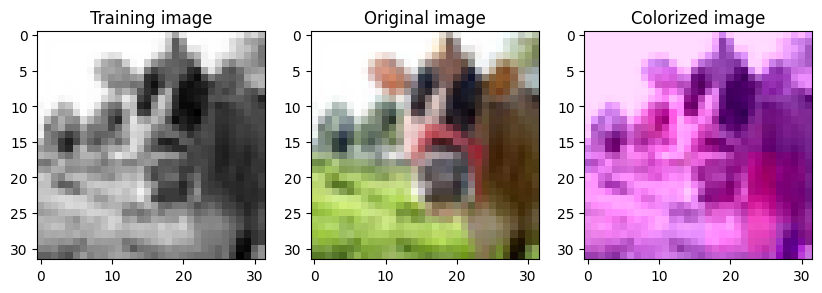

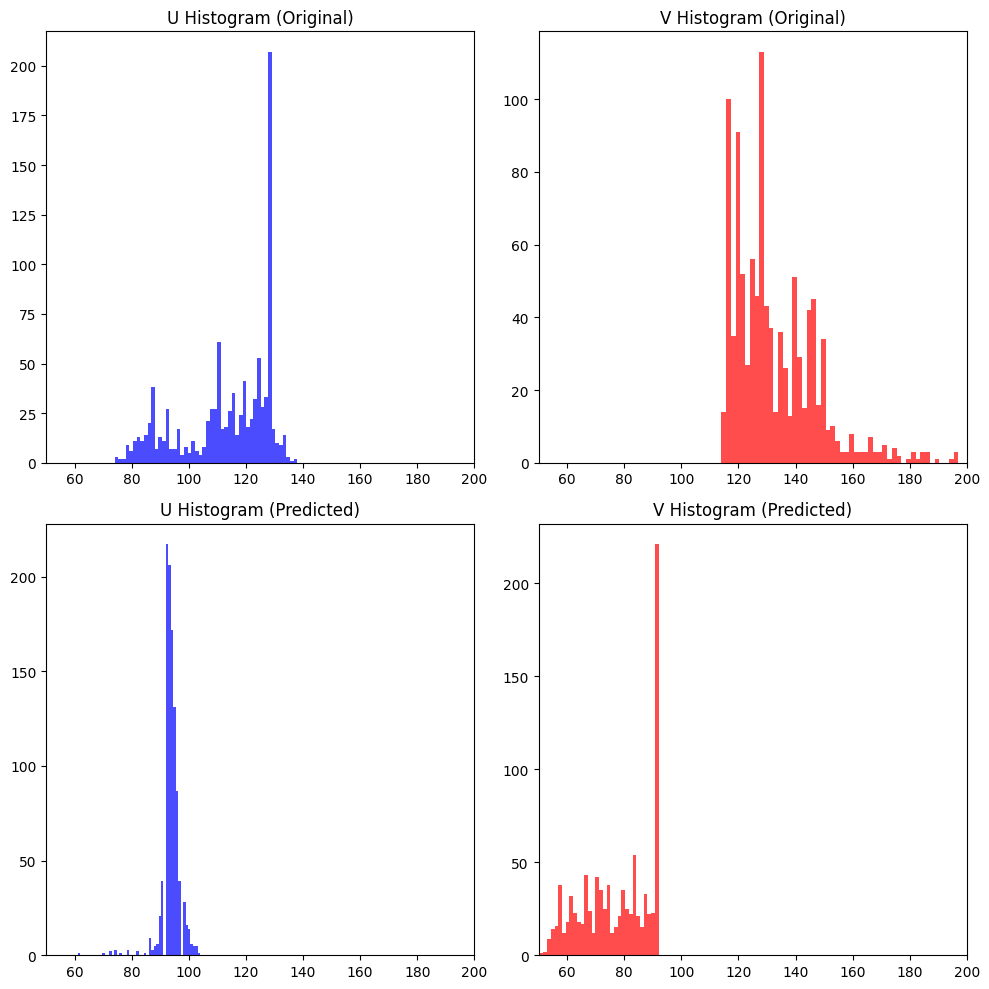

ORIGINAL IMAGE RANGE (tensor(0.1451), tensor(1.))
YUV image range: (58, 255)
Colorized image range: (0.007843138, 1.0)


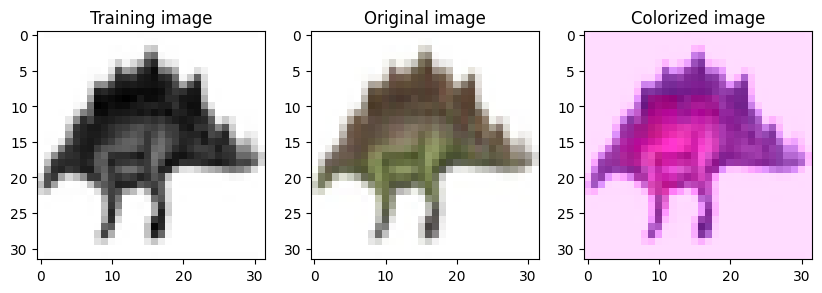

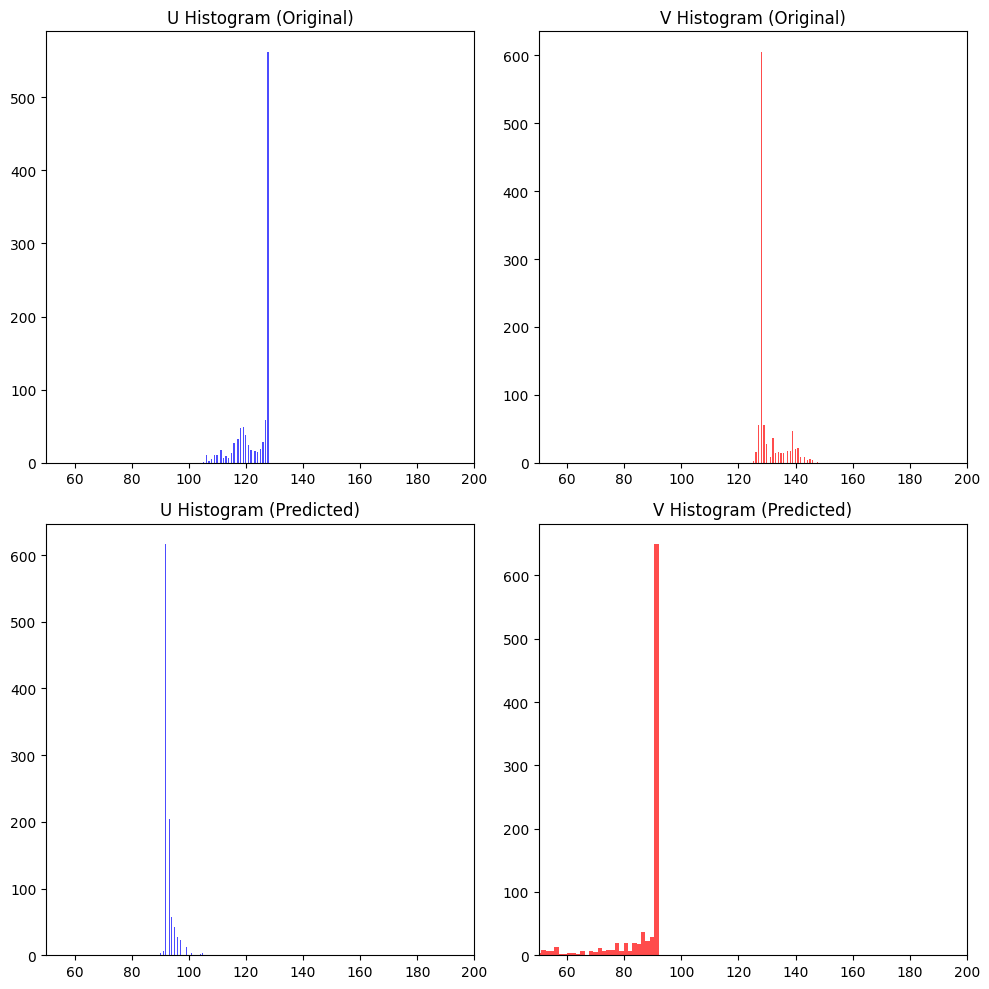

ORIGINAL IMAGE RANGE (tensor(0.0902), tensor(0.9882))
YUV image range: (52, 254)
Colorized image range: (0.0, 1.0)


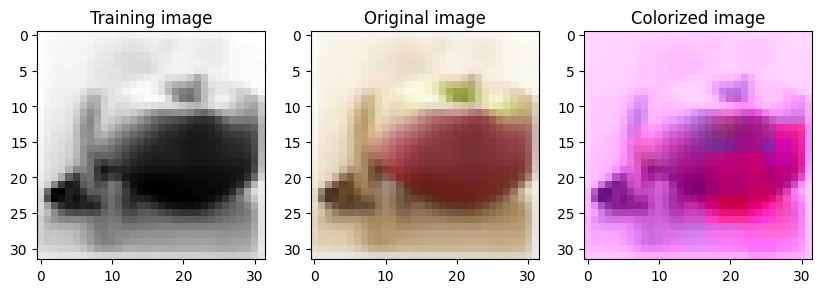

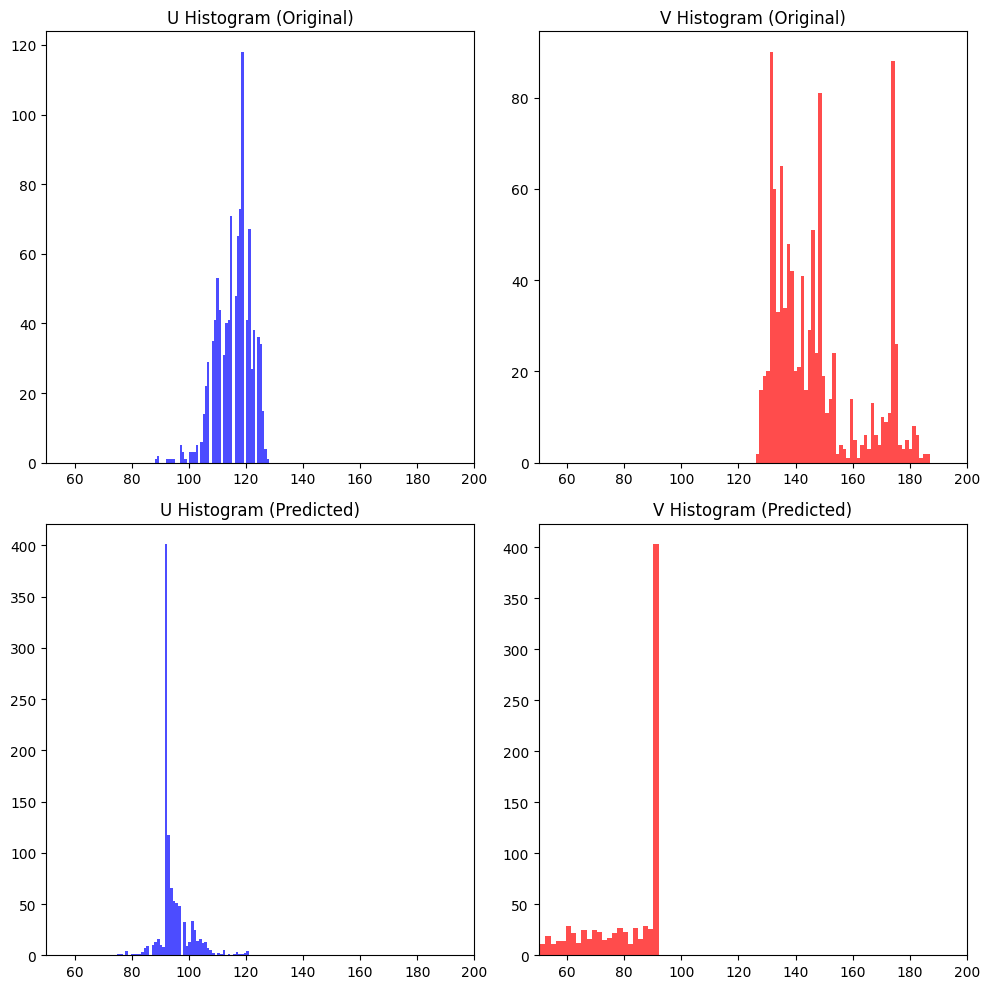

ORIGINAL IMAGE RANGE (tensor(0.), tensor(1.))
YUV image range: (1, 250)
Colorized image range: (0.0, 1.0)


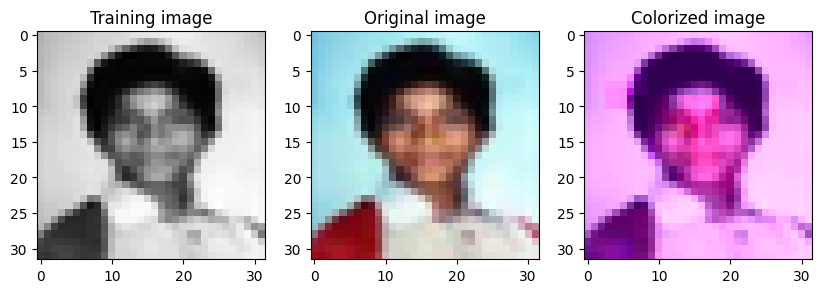

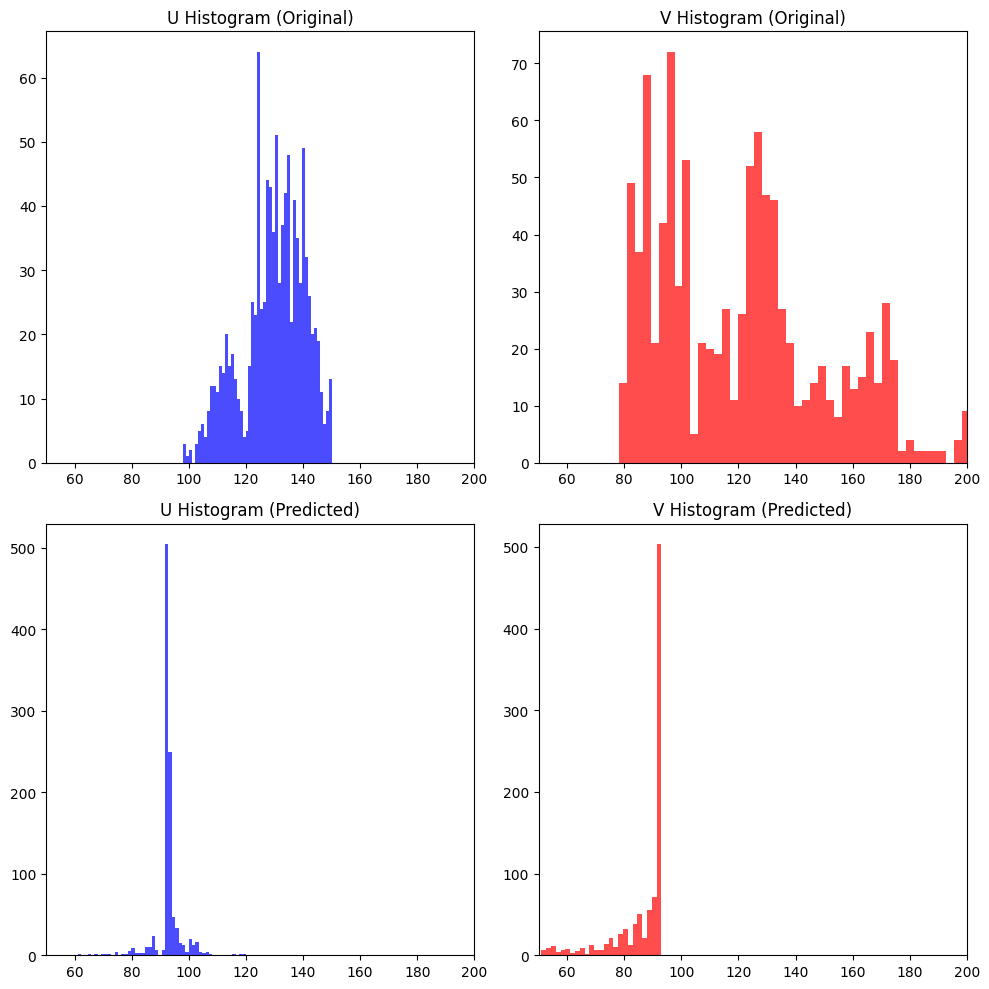

In [ ]:
# maybe some skip connection can improve the performances 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YUVColorizationNet().to(device)
model.load_state_dict(torch.load("yuv_colorization_model.pth"))

dataset = YUVImageDataset(filenames = filenames, images_data = images_data, transform = transform )

org_dataset = CustomDataset(filenames=filenames, images_data=images_data, transform=transform)
org_train =  DataLoader(org_dataset, batch_size=32, shuffle = False)

def colorize_image(model, y_channel):
    model.eval()
    
    # Ensure y_channel is in the correct format: [batch, 1, H, W]
    y_channel = y_channel.clone().detach().to(torch.float32).to(device)  
    if y_channel.dim() == 3:  
        y_channel = y_channel.unsqueeze(0)  # Add batch dim only if needed
    
    with torch.no_grad():
        uv_pred = model(y_channel).cpu().squeeze(0)  # Remove batch dim
    
    return uv_pred.numpy()


# Let's try to visualize some outputs of the networks
n_out = 4
for batch in org_train:
    for i in range(n_out):
        # Load a grayscale Y channel image and predict colorization
        y_input = dataset[i][0].unsqueeze(0)  # Example input (1, H, W)
        
        uv_output = colorize_image(model, y_input)  # Given the Y input, the algorithm should be able of predicting the UV colors
        # Convert back to RGB

        u = uv_output[0] 
        v = uv_output[1] 
  
        #yuv_image = np.concatenate([y_input[0, :, :, :], uv_output[0:1, :, :]], axis=0)  # (3, H, W)
        yuv_image = np.stack([y_input[0, 0, :, :], u, v], axis=-1)

        #yuv_image = np.transpose(yuv_image, (1, 2, 0))  # Convert to (H, W, 3) to use cv2
        # Also values should be multiplied by 255 for conversion to RGB range

        yuv_image = (yuv_image * 255).astype(np.uint8)
        #yuv_image = np.abs(yuv_image)
        rgb_colorized = cv2.cvtColor(yuv_image, cv2.COLOR_YUV2RGB)
        rgb_colorized = rgb_colorized.astype(np.float32) / 255
        #bgr_colorized = cv2.cvtColor(rgb_colorized, cv2.COLOR_BGR2RGB)
 
        image_tensor, _, _ = batch  # Estrai dati dal batch

        org_rgb = image_tensor[i, :, :, :]  # First batch image 
        image_yuv = rgb_to_yuv(org_rgb)       

        org_rgb = np.transpose(org_rgb, (1, 2, 0))


        print(f'ORIGINAL IMAGE RANGE {org_rgb.min(), org_rgb.max()}')
        print(f'YUV image range: {yuv_image.min(), yuv_image.max()}')
        print(f'Colorized image range: {rgb_colorized.min(), rgb_colorized.max()}')
        
        plt.figure(figsize = (10,5))
        plt.subplot(1, 3, 1)
        plt.imshow(image_yuv[0], cmap = 'gray')
        plt.title('Training image')

        plt.subplot(1, 3, 2)
        plt.imshow(org_rgb)
        plt.title('Original image')
        

        plt.subplot(1, 3, 3)
        plt.imshow(rgb_colorized)
        plt.title("Colorized image")


        # ----------------- Hystogram plots ------------------------
        
        plt.figure(figsize = (10, 10))
        plt.subplot(2, 2, 1)
        plt.hist(image_yuv[1].flatten(), bins = 50, color = 'blue', alpha = 0.7)
        plt.xlim(50, 200)
        plt.title("U Histogram (Original)")


        plt.subplot(2, 2, 2)
        plt.hist(image_yuv[2].flatten(), bins=50, color='red', alpha=0.7)
        plt.xlim(50, 200)
        plt.title("V Histogram (Original)")

        plt.subplot(2, 2, 3)
        plt.hist(yuv_image[:, :, 1].flatten() * 255, bins=50, color='blue', alpha=0.7)
        plt.xlim(50, 200)
        plt.title("U Histogram (Predicted)")

        plt.subplot(2, 2, 4)
        plt.hist(yuv_image[:, :, 2].flatten() * 255, bins=50, color='red', alpha=0.7)
        plt.xlim(50, 200)
        plt.title("V Histogram (Predicted)")

        plt.tight_layout()
        plt.show()



        
    break 
    

As we can observe from the preceiding results, regression is not performing well on our task. This can be explained considering that the loss implemented is computing an average on all the possible colors, resulting in a grayish color palette.

In [ ]:
# Model improvement 
# - Predicting the u values and feed the network with them in order to obtain the v values
# - Apply binning to the initial values of regression
# - Try to change the tanh function 

# For classification:
# Try to implement a simpler model 

## CNN Regression improvement 

In the next section we are trying to implement a different structure for our model: the network will first try to get the correct u value and then the updated model will be used to train for the v value.

In [24]:
# ----- DATASET -----
class YUVImageDataset_mod2(Dataset):
    '''
    This class takes in input the whole dataset and prepares it for training
    by loading images, converting them to YUV format and normalizing the channels
    The target is a vector formed by U and V values, used to compute the loss 
    In this case the target will be formed by the U channel only
    '''
    def __init__(self, filenames, images_data, transform=None):
        self.filenames = filenames
        self.images_data = images_data 
        self.transform = transform

    def __len__(self):
        return len(self.images_data)

    def __getitem__(self, idx):
        img_data = self.images_data[idx]

        img_rgb = np.array(img_data, dtype=np.uint8).reshape(3, 32, 32)  # Assuming RGB: the images that we read are in the RGB forma
        img_rgb = np.transpose(img_rgb, (1, 2, 0))  # Convert to HWC format

        image_yuv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2YUV)  


        # Normalization is done in order to improve the stability of the network 
        Y_channel = image_yuv[:, :, 0] / 255.0  # Normalize to [0, 1]
        U_channel = image_yuv[:, :, 1] / 255.0  # Normalize to [0, 1]
        V_channel = image_yuv[:, :, 2] / 255.0  # Normalize to [0, 1]

        # Add channel dimension (H, W) -> (1, H, W)
        Y_channel = np.expand_dims(Y_channel, axis=0)  
        U_channel = np.expand_dims(U_channel, axis=0)
        V_channel = np.expand_dims(V_channel, axis=0)


        # Convert to tensors
        Y_channel = torch.tensor(Y_channel, dtype=torch.float32)
        u_target = torch.tensor(U_channel , dtype=torch.float32)
        v_target = torch.tensor(V_channel, dtype = torch.float32)

        return Y_channel, u_target, v_target 


In [25]:
class Phase1Network(nn.Module):
    def __init__(self):
        super(Phase1Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)  # Output channel for U

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        u_channel = self.conv4(x)
        return u_channel


class Phase2Network(nn.Module):
    def __init__(self):
        super(Phase2Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)  # Takes both Y and U
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)  # Output channel for V

    def forward(self, x):
        #x = torch.cat((y), dim=1)  # Concatenate Y and U along the channel dimension
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        v_channel = self.conv4(x)
        return v_channel


class YUVColorizationNetwork(nn.Module):
    def __init__(self):
        super(YUVColorizationNetwork, self).__init__()
        self.phase1 = Phase1Network()  # For predicting U
        self.phase2 = Phase2Network()  # For predicting V

    def forward(self, y):
        u = self.phase1(y)  # Predict U channel from Y
        v = self.phase2(y)  # Predict V channel from Y 
        return u, v


In [ ]:
## ---------------------------- RUN ONLY DURING TRAINING ----------------------------------------------


# Define the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YUVColorizationNetwork().to(device)
#model = YUVColorizationNetwork()

optimizer_u = optim.Adam(model.parameters(), lr=0.001)
optimizer_v = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.MSELoss()

# Assuming you have the filenames and images_data ready
train_dataset = YUVImageDataset_mod2(filenames, images_data)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Training Loop
num_epochs = 20  # Adjust the number of epochs based on your needs
for epoch in range(num_epochs):
    for batch in train_loader:
        # Get Y input and U target from the dataset
        y_input, u_target, v_target = batch  # y_input is the Y channel, u_target is the U channel

        y_input = y_input.to(device)
        u_target = u_target.to(device)
        v_target = v_target.to(device)


        # ---------------------- Predicting u ------------------------------------
        optimizer_u.zero_grad()
        u_pred, _ = model(y_input) #ignoring the v prediction  

        # Compute loss for U and V channels
        loss_u = criterion(u_pred, u_target)
        loss_u.backward()
        optimizer_u.step() 

        # ----------------- Predicting v ---------------------
        optimizer_v.zero_grad()
        _, v_pred = model(y_input)
        loss_v = criterion(v_pred, v_target)  # You can compute V loss too if you have ground truth for V
        loss_v.backward()
        optimizer_v.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], \n Loss for u: {loss_u.item():.4f}, \n Los for v: {loss_v.item():.4f} \n ----------------------------------------z-")


Epoch [1/20], 
 Loss for u: 0.0025, 
 Los for v:0.0041 
 ----------------------------------------z-
Epoch [2/20], 
 Loss for u: 0.0044, 
 Los for v:0.0067 
 ----------------------------------------z-
Epoch [3/20], 
 Loss for u: 0.0028, 
 Los for v:0.0053 
 ----------------------------------------z-
Epoch [4/20], 
 Loss for u: 0.0028, 
 Los for v:0.0078 
 ----------------------------------------z-
Epoch [5/20], 
 Loss for u: 0.0025, 
 Los for v:0.0039 
 ----------------------------------------z-
Epoch [6/20], 
 Loss for u: 0.0019, 
 Los for v:0.0046 
 ----------------------------------------z-
Epoch [7/20], 
 Loss for u: 0.0024, 
 Los for v:0.0048 
 ----------------------------------------z-
Epoch [8/20], 
 Loss for u: 0.0040, 
 Los for v:0.0089 
 ----------------------------------------z-
Epoch [9/20], 
 Loss for u: 0.0044, 
 Los for v:0.0119 
 ----------------------------------------z-
Epoch [10/20], 
 Loss for u: 0.0029, 
 Los for v:0.0076 
 ----------------------------------------z-

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YUVColorizationNetwork().to(device)
torch.save(model.state_dict(), 'two_phase_model.pth')


In [162]:

model.load_state_dict(torch.load("two_phase_model.pth"))

dataset = YUVImageDataset_mod2(filenames = filenames, images_data = images_data, transform = transform )

org_dataset = CustomDataset(filenames=filenames, images_data=images_data, transform=transform)
org_train =  DataLoader(org_dataset, batch_size=32, shuffle = False)

C:\Users\adadi\AppData\Local\Temp\ipykernel_23420\3858704002.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("two_phase_model.pth"))


RuntimeError: Error(s) in loading state_dict for YUVColorizationNet:
	Missing key(s) in state_dict: "encoder.0.weight", "encoder.0.bias", "encoder.2.weight", "encoder.2.bias", "encoder.5.weight", "encoder.5.bias", "decoder.0.weight", "decoder.0.bias", "decoder.2.weight", "decoder.2.bias", "decoder.4.weight", "decoder.4.bias". 
	Unexpected key(s) in state_dict: "phase1.conv1.weight", "phase1.conv1.bias", "phase1.conv2.weight", "phase1.conv2.bias", "phase1.conv3.weight", "phase1.conv3.bias", "phase1.conv4.weight", "phase1.conv4.bias", "phase2.conv1.weight", "phase2.conv1.bias", "phase2.conv2.weight", "phase2.conv2.bias", "phase2.conv3.weight", "phase2.conv3.bias", "phase2.conv4.weight", "phase2.conv4.bias". 

In [74]:
def yuv_to_rgb(yuv_image):
    y = yuv_image[:, :, 0]
    u = yuv_image[:, :, 1]
    v = yuv_image[:, :, 2]

    rgb_image = np.zeros(yuv_image.shape)
    rgb_image[:, :, 0] = 1.164 * (y - 16) + 1.596 * (v - 128)
    rgb_image[:, :, 1] = 1.164 * ( y - 16) - 0.813 * (v - 128) - 0.391 * (u - 128)
    rgb_image[:, :, 2] = 1.164 * (y - 16) + 2.018 * (u - 128)

    return rgb_image 

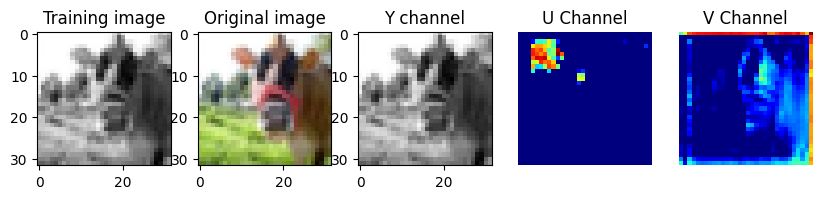

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.029847024..1.0558926].


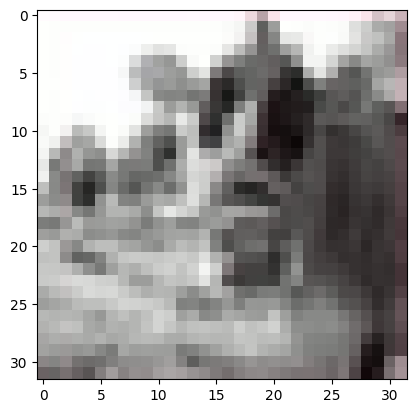

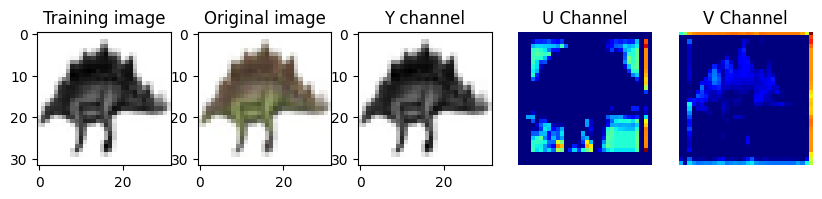

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.22332187..1.0721153].


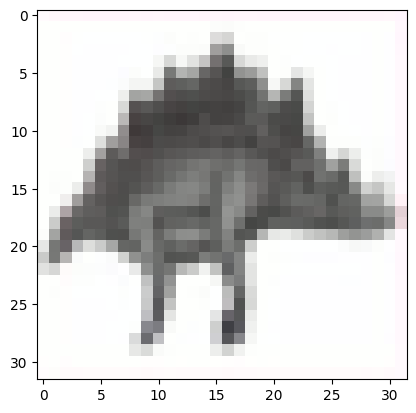

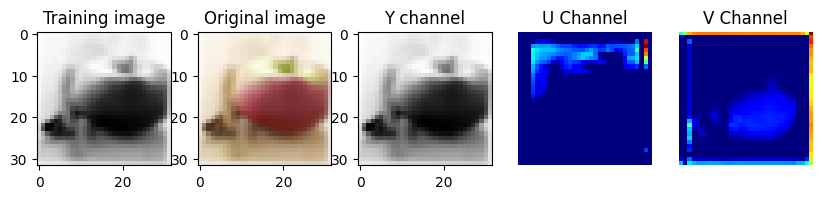

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.19954184..1.0478716].


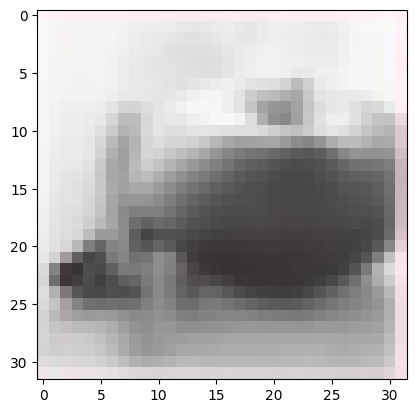

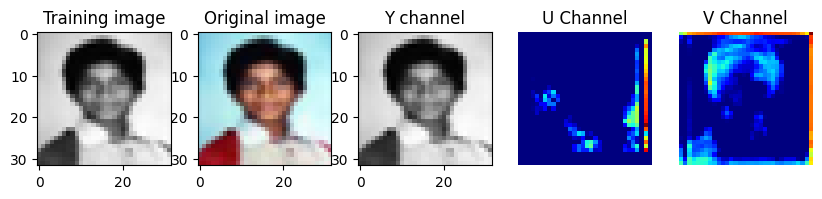

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.008042862..0.99466866].


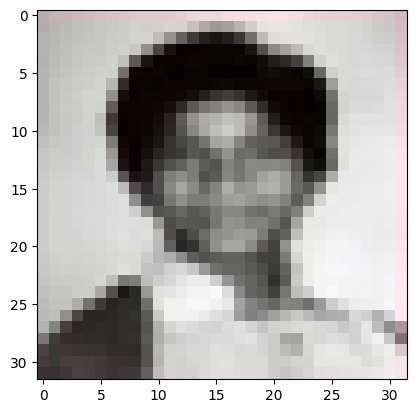

In [40]:
def colorize_image_2(model, y_input, device='cuda'):
    """
    Colorizes an image using the trained model. 
    y_input is the Y channel of the grayscale image.
    
    Parameters:
    - model: The trained model
    - y_input: Grayscale Y channel image (1, H, W)
    - device: The device to use for prediction ('cuda' or 'cpu')
    
    Returns:
    - colorized_image: The colorized RGB image
    """
    model.to(device)
    model.eval()  # Set the model to evaluation mode
    
    # Ensure the input is on the same device as the model
    y_input = y_input.to(device)
    
    with torch.no_grad():  # Disable gradient tracking for inference
        u_pred, v_pred = model(y_input)  # Predict the U and V channels
    
    # Convert predictions to numpy arrays (if they are on GPU, move them to CPU first)
    u_pred = u_pred.cpu().numpy().squeeze(0)  # Remove batch dimension
    v_pred = v_pred.cpu().numpy().squeeze(0)  # Remove batch dimension
    
    # Rescale U and V channels from [0, 1] back to [0, 255]
    
    u_pred = np.clip(u_pred * 255, 0, 255) #.astype(np.uint8)
    v_pred = np.clip(v_pred * 255, 0, 255)  #.astype(np.uint8)

    # Combine the Y, U, and V channels into one YUV image
    yuv_image = np.stack([y_input.cpu().numpy().squeeze(0) * 255, u_pred, v_pred], axis=-1)

    
    return yuv_image

n_out = 4
for batch in org_train:
    for i in range(n_out):
        # Load a grayscale Y channel image and predict colorization
        y_input = dataset[i][0].unsqueeze(0)  # Example input (1, H, W)
        
        yuv_output = colorize_image_2(model, y_input)  # Given the Y input, the algorithm should be able of predicting the UV colors


        # Convert the YUV image back to RGB
        rgb_output = cv2.cvtColor(yuv_output[0], cv2.COLOR_YUV2RGB)

        # Convert back to RGB
        
        image_tensor, _, _ = batch  # Estrai dati dal batch

        org_rgb = image_tensor[i, :, :, :]  # First batch image 
        image_yuv = rgb_to_yuv(org_rgb)       
        yuv_output = yuv_output[0]
    
        org_rgb = np.transpose(org_rgb, (1, 2, 0))


        rgb_output_1 = cv2.cvtColor(yuv_output, cv2.COLOR_YUV2RGB)
        rgb_output = yuv_to_rgb(yuv_output)

        #print(rgb_output)

        plt.figure(figsize = (10,5))
        plt.subplot(1, 5, 1)
        plt.imshow(image_yuv[0], cmap = 'gray')
        plt.title('Training image')

        plt.subplot(1, 5, 2)
        plt.imshow(org_rgb)
        plt.title('Original image')
        
        plt.subplot(1, 5, 3)
        plt.imshow(yuv_output[:, :, 0] , cmap = 'gray')
        plt.title("Y channel")


        # Canale Y
        plt.subplot(1, 5, 4)
        plt.imshow(yuv_output[:, :, 1] , cmap='jet')  
        plt.title('U Channel')
        plt.axis('off')

        # Canale U
        plt.subplot(1, 5, 5)
        plt.imshow(yuv_output[:, :, 2] , cmap = 'jet') 
        plt.title('V Channel')
        plt.axis('off')

        plt.show()
        plt.imshow(rgb_output_1 / 255)

        plt.show()

    break 




In [ ]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version (PyTorch): {torch.version.cuda}")


## Classification network 

J. Hwang, Y.Zhou (https://cs231n.stanford.edu/reports/2016/pdfs/219_Report.pdf)


The general idea is as follows: in the preceding section we have used a regression model in order to solve the problem. Now we want to perform classification. In order to perform classification on continuous data, we must discretize the domain. The targets $U$ and $V$ from the $CIELUV$ color space take on values in the interval $[-100, 100]$. We implecitly discretize this space into 50 equi-width bins by applying a binning function to each input image prior to feeding it to the input of the network. The function returns an array of the same shape as the original image with each $U$ and $V$ value mapped to some value in the interval $[0, 49]$. Then, instead of directly predicting numeric values for $U$ and $V$, the network outputs two separate sets of the most probable bin numbers for the pixels, one for each channel. We used the sum of cross-entropy loss on the two channels as our minimization objective.

A final concatenation layer is formed by different steps inside the network. It is followed by the final two parallel 1 x 1 convolutional layers corresponding to the $U$ and $V$ channels. These 1 x 1 convolutional layers act as the fully-connected layers to produce 50 class scores for each channel for each pixel of the image. The classes with the largest sccores on each channel are then selected as the predicted bin numbers. Via un-binning function, we then convert the predicted bins back to numerical $U$ and $V$ values using the means of the selected bins.

In [16]:
# color conversion ran on local without gpu
def rgb_yuv(array):
    array = torch.Tensor(array).permute(1,2,0).cpu().numpy()
    return torch.Tensor(cv2.cvtColor(array,cv2.COLOR_RGB2YUV))
    

def yuv_rgb(array):
    array= cv2.cvtColor(array,cv2.COLOR_YUV2RGB)
    return torch.Tensor((array*255).astype(np.uint8).permute(2,0,1))

In [ ]:
# color conversion ran on local without gpu
def rgb_yuv(array):
    array = torch.Tensor(array).permute(1,2,0).cpu().numpy()
    return torch.Tensor(cv2.cvtColor(array,cv2.COLOR_RGB2YUV))
    

def yuv_rgb(array):
    array= cv2.cvtColor(array,cv2.COLOR_YUV2RGB)
    return torch.Tensor((array*255).astype(np.uint8).permute(2,0,1))

In [8]:
# --- SIMPLIFIED NETWORK -------------


# ----- DATASET -----
class YUVImageClassificationDataset(Dataset):
    def __init__(self, filenames, images_data, bin_count=50, transform=None):
        self.filenames = filenames # filenames of the files
        self.images_data = images_data # images data: data used to construct the images 
        self.transform = transform
        self.bin_count = bin_count # number of bins used 
        self.bins = np.linspace(0, 1, bin_count + 1)  # Bin edges
        # we are creating bins between 0 and 1 in order to have the values of u and v 

    def bin_labels(self, values):
        return np.digitize(values, self.bins) - 1  # Map values to bin indices
                                                   # This function takes values and assigns each value to a bin index
                                                   # based on self.bins. It returns the index starting from 0

    def __len__(self):
        return len(self.images_data)

    def __getitem__(self, idx):
        img_data = self.images_data[idx]
        img_rgb = np.array(img_data, dtype=np.uint8).reshape(3, 32, 32)
        #img_rgb = np.transpose(img_rgb, (1, 2, 0))

        #image_yuv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2Luv) # Converting to the CIELUV scale 
        image_yuv = rgb_yuv(img_rgb)
        Y_channel = image_yuv[:, :, 0] #/ 255.0  # Normalize Y to [0, 1] for stability of the network 
        U_channel = image_yuv[:, :, 1] #/ 255.0   # Convert to range [-128, 127]
        V_channel = image_yuv[:, :, 2] #/ 255.0

        U_binned = self.bin_labels(U_channel)  # Discretize U 
        V_binned = self.bin_labels(V_channel)  # Discretize V

        Y_channel = np.expand_dims(Y_channel, axis=0)

        Y_channel = torch.tensor(Y_channel, dtype=torch.float32) # transform into tensor to use pytorch 
        U_binned = torch.tensor(U_binned, dtype=torch.long)
        V_binned = torch.tensor(V_binned, dtype=torch.long)

        
        return Y_channel, U_binned, V_binned

# ----- CLASSIFICATION CNN MODEL -----
class ClassificationCNN(nn.Module):
    def __init__(self, num_classes=50):
        super(ClassificationCNN, self).__init__()
        
        # Initial Convolutional Layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)
        
        # Second Convolutional Block
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)
        
        # Skip Connections
        self.skip0 = nn.Conv2d(64, 128, kernel_size=3, padding = 1)
        
        self.conv_final = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1), nn.ReLU()
        )
        
        # Output Layers for Classification
        self.output_U = nn.Conv2d(64, num_classes, kernel_size=3, padding=1)
        self.output_V = nn.Conv2d(64, num_classes, kernel_size=3, padding=1)
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, x):
        x1 = self.conv1(x)
        x1_pooled = self.pool1(x1)
        
        x2 = self.conv2(x1_pooled)
        x2_pooled = self.pool2(x2)
        x2_pooled_padded = F.interpolate(x2_pooled, size=(32, 32), mode='bilinear', align_corners=False)

        x1_conv = self.skip0(x1)
        x2_padded = F.interpolate(x2, size=(32, 32), mode='bilinear', align_corners=False)
        el_wise = x1_conv + x2_padded
        
        # Concatenation layer
        x_concat = torch.cat([el_wise, x2_pooled_padded], dim=1) # necessitano solo stessa H e W

        # Final convolutional processing
        x_final = self.conv_final(x_concat)

        U_out = self.output_U(x_final)
        V_out = self.output_V(x_final)

        return U_out, V_out


In [20]:
# ----- RUN ONLY DURING TRAINING -----
train_set = unpickle('train')
filenames = [f.decode('utf-8') for f in train_set[b'filenames']]
images_data = train_set[b'data']

bin_count = 50 # number of bins used to group the values u,v 
dataset = YUVImageClassificationDataset(filenames, images_data, bin_count)
train_loader = DataLoader(dataset, batch_size=8, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ClassificationCNN(bin_count).to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
total_loss = []
# Training Loop
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for Y_channel, U_target, V_target in train_loader:
        Y_channel, U_target, V_target = Y_channel.to(device), U_target.to(device), V_target.to(device)
        #print('U target: \n', U_target)

        optimizer.zero_grad()
        U_pred, V_pred = model(Y_channel)
        #print('U pred: \n',U_pred)

        loss_U = criterion(U_pred, U_target)
        loss_V = criterion(V_pred, V_target)
        loss = loss_U + loss_V

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Save Model
torch.save(model.state_dict(), f"models/yuv_classification_{num_epochs}ep.pth")

NameError: name 'optimizer' is not defined

In [ ]:
# unbinning with a softmax we can also use the class rebalancing here or we introduce temperature
def converter(pred):
    '''
    Takes the predictions in a bin format and retrieves the index 
    of the bin with highest probability
    '''
    softmax = nn.Softmax(dim = 1)
    probs = softmax(pred) # normalizing output between 0 and 1
    _, ind = torch.topk(probs,1,1) # returns indices of the classes with the highest score, 
                                   # i.e. the highest probability 
    return ind

def unbin_labels(bins, bin_indices):
    bin_indices = np.clip(bin_indices.detach().cpu().numpy(), 0, len(bins) - 2) # it assures that all bin indices are between 0 and len(bins) - 2, 
                                                                                # so that there are no outliers 
    return bins[bin_indices] # returns the value of the corresponding bin to each index 


In [56]:
# Loading the model 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ClassificationCNN().to(device)
model.load_state_dict(torch.load("yuv_classification_30ep.pth"))

dataset = YUVImageClassificationDataset(filenames, images_data)

org_dataset = CustomDataset(filenames = filenames, images_data = images_data, transform = transform)
org_train = DataLoader(org_dataset, batch_size = 8, shuffle = False)

train_loader = DataLoader(dataset, batch_size = 8, shuffle = False)


C:\Users\adadi\AppData\Local\Temp\ipykernel_26128\3143142266.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("yuv_classification_30ep.pt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0409196442248774..1.693115713082108].


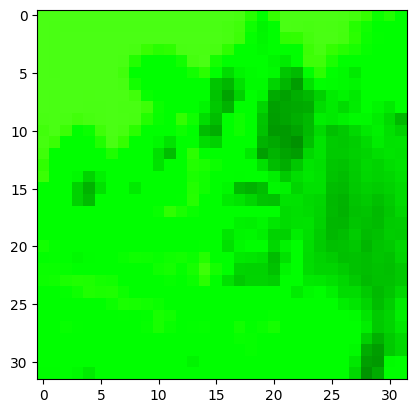

In [77]:
# Extracting values from the trained network 
n_out = 4
for batch in train_loader:
    for i in range(n_out):
        # Let's just display some results 
        y_input = dataset[i][0].unsqueeze(0)
        U_target = dataset[i][1].unsqueeze(0)
        V_target = dataset[i][2].unsqueeze(0)
        #y_input, U_target, V_target = batch 

        y_input, U_target, V_target = y_input.to(device), U_target.to(device), V_target.to(device)
       
        #print(f'y_input shape: {y_input.shape}')
        #print(f'U_target shape: {U_target.shape}')
        #print(f'V_target shape: {V_target.shape}')

        U_pred, V_pred = model(y_input)

        #print(f'U_pred shape: {U_pred.shape}')
        #print(f'V_pred shape: {V_pred.shape}')        

        conv_pred_U = converter(U_pred) # returns the index of the bin with highest probability 
        conv_pred_V = converter(V_pred)


        bins = np.linspace(0, 1, bin_count + 1)  # Bin edges

        U_target_rec = unbin_labels(bins, U_target) # retrieves bins[U_target] -> U_target containes the bin corresponding to the correct color value
                                                    # gives back the bin values, i.e. values of the uv scale between 0 and 1 

        U_target_rec_tensor = torch.tensor(U_target_rec, dtype=torch.float32)#.resize(8, 1,32,32)

        U_reconstructed = unbin_labels(bins, conv_pred_U)
        U_reconstructed_tensor = torch.tensor(U_reconstructed, dtype=torch.float32)

        V_target_rec = unbin_labels(bins, V_target)
        V_target_rec_tensor = torch.tensor(V_target_rec , dtype=torch.float32)#.resize(8, 1,32,32)
        V_reconstructed = unbin_labels(bins, conv_pred_V)
        V_reconstructed_tensor = torch.tensor(V_reconstructed, dtype=torch.float32)


        # Given the reconstructed image, let's display some result 
        #U_reconstructed_tensor = U_reconstructed_tensor * 255
        #V_reconstructed_tensor = V_reconstructed_tensor * 255

        yuv_image = np.stack([
        y_input.cpu().numpy(),  
        U_reconstructed_tensor.cpu().numpy(),  
        V_reconstructed_tensor.cpu().numpy()
        ], axis=-1)
       
        rgb_image = yuv_to_rgb(yuv_image[0, 0, :, : , :])

        plt.imshow(rgb_image / 255)
        plt.show()


        break 

    break 


In [61]:
reconstructed_pred = torch.cat([Y_channel,U_reconstructed_tensor.to(device),V_reconstructed_tensor.to(device)],dim=1)
reconstructed_img = torch.cat([Y_channel,U_target_rec_tensor.to(device),V_target_rec_tensor.to(device)],dim=1)

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 32 but got size 8 for tensor number 1 in the list.

In [ ]:
rec_img_rgb = yuv_rgb(reconstructed_img.cpu().numpy()[0])
imshow(rec_img_rgb)

In [22]:
# unbinning with a softmax we can also use the class rebalancing here or we introduce temperature
def converter(pred):
    softmax = nn.Softmax(dim = 1)
    probs = softmax(pred)
    _, ind = torch.topk(probs,1,1)
    return ind

conv_pred_U = converter(U_pred)
conv_pred_V = converter(V_pred)

def unbin_labels(bins, bin_indices):
    bin_indices = np.clip(bin_indices.detach().cpu().numpy(), 0, len(bins) - 2)
    return bins[bin_indices]

bins = np.linspace(0, 1, bin_count + 1)  # Bin edges

U_target_rec = unbin_labels(bins, U_target)
U_target_rec_tensor = torch.tensor(U_target_rec, dtype=torch.float32).resize(8,1,32,32)
U_reconstructed = unbin_labels(bins, conv_pred_U)
U_reconstructed_tensor = torch.tensor(U_reconstructed, dtype=torch.float32)

V_target_rec = unbin_labels(bins, V_target)
V_target_rec_tensor = torch.tensor(V_target_rec , dtype=torch.float32).resize(8,1,32,32)
V_reconstructed = unbin_labels(bins, conv_pred_V)
V_reconstructed_tensor = torch.tensor(V_reconstructed, dtype=torch.float32)



C:\Users\adadi\AppData\Local\Temp\ipykernel_26128\2849957952.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("yuv_classification_30ep.pt

In [53]:
reconstructed_pred = torch.cat([Y_channel,U_reconstructed_tensor.to(device),V_reconstructed_tensor.to(device)],dim=1)
reconstructed_img = torch.cat([Y_channel,U_target_rec_tensor.to(device),V_target_rec_tensor.to(device)],dim=1)

In [69]:
# Load the model and evaluate the result 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ClassificationCNN().to(device)
model.load_state_dict(torch.load("yuv_classification_30ep.pth"))

dataset = YUVImageClassificationDataset(filenames, images_data)

org_dataset = CustomDataset(filenames = filenames, images_data = images_data, transform = transform)
org_train = DataLoader(org_dataset, batch_size = 32, shuffle = False)
# The dataset has been uploaded, now let's try to evaluate the model 

train_loader = DataLoader(dataset, batch_size = 8, shuffle = False)

data_iter = iter(train_loader)
print(data_iter)
images, labels = next(data_iter)

images = images.to(device)

model.eval()

with torch.no_grad(): # gradient off
    outputs = model(images)

images = images.cpu().numpy().transpose(0, 2, 3, 1)

fig, axes = plt.subplots(1, len(images), figsize = (15, 5))

for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.set_title(f"Pred: {torch.argmax(outputs[i]).item()}")
    ax.axis("off")

plt.show()

error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-15:Bad number of channels) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3>; VDcn = cv::impl::{anonymous}::Set<3, 4>; VDepth = cv::impl::{anonymous}::Set<0, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 32
